Zastosuj modele [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) i [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) do przewidywania wartości `medv` na podstawie pozostałych zmiennych w zbiorze `boston.csv`. 

Wykonaj kroki analogiczne do Zadania 1.
- Podziel dane na zbiór treningowy i testowy. Ze zbioru treningowego wydziel dodatkowo zbiór walidacyjny lub stosuj walidację krzyżową.
- Stwórz model [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 
- Zmniejsz rozmiar drzewa stosując 'przycinanie' (pruning). Wygeneruj wartości `ccp_alpha` metodą `cost_complexity_pruning_path()`. Użyj zbioru walidacyjnego lub walidacji krzyżowej (np. [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) aby znaleźć najlepszą wartość. Zobacz, jak to zrobić w dokumentacji: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
- Porównaj modele przed i po przycinaniu. Jak wpłynęło na jakość predykcji? Jak zmienił się rozmiar drzewa (sprawdź metodami `get_depth()`, `get_n_leaves()`)?
- Sprawdź jaki wpływ na jakość predykcji ma regulowanie rozmiaru drzewa, np. parametrami `max_depth`, `max_leaf_nodes`.
- Stwórz model [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) i porównaj go z wcześniej tworzonymi modelami.
- Wybierz najlepsze ze stworzonych drzew decyzyjnych, biorąc pod uwagę zarówno jakość predykcji, jak i rozmiar drzewa. Wizualizuj drzewo metodą [`plot_tree()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html). Dokonaj ewaluacji korzystając ze zbioru testowego.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier

In [40]:
df = pd.read_csv("../data/boston.csv")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [41]:
print(df.shape)
df.info()

(506, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [42]:
# Describe medv
print(df['medv'].describe())

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64


In [43]:
df['MedvHigh'] = df['medv'].apply(lambda x: "Yes" if x >= 21.2 else "No")
df = df.drop(columns=['medv'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,MedvHigh
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,Yes
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,Yes
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,Yes
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,Yes
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,Yes


### Decision Tree Classifier

In [44]:
X = df.drop(columns=["MedvHigh"])
y = df["MedvHigh"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

In [45]:
feature_names = X.columns.tolist()
# (SalesHigh_Yes: False to 'No', True to 'Yes')
class_names = ['No', 'Yes']

In [46]:
dtc = DecisionTreeClassifier(random_state=17)
dtc.fit(X_train, y_train)

# Evaluation on test dataset
# Overfitting - model remembers the training dataset
y_pred_train = dtc.predict(X_train)
print("Model before pruning - evaluation on train dataset:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Tree depth: {dtc.get_depth()}")
print(f"Amount of leaves: {dtc.get_n_leaves()}")

Model before pruning - evaluation on train dataset:
Accuracy: 1.0000
Tree depth: 11
Amount of leaves: 46


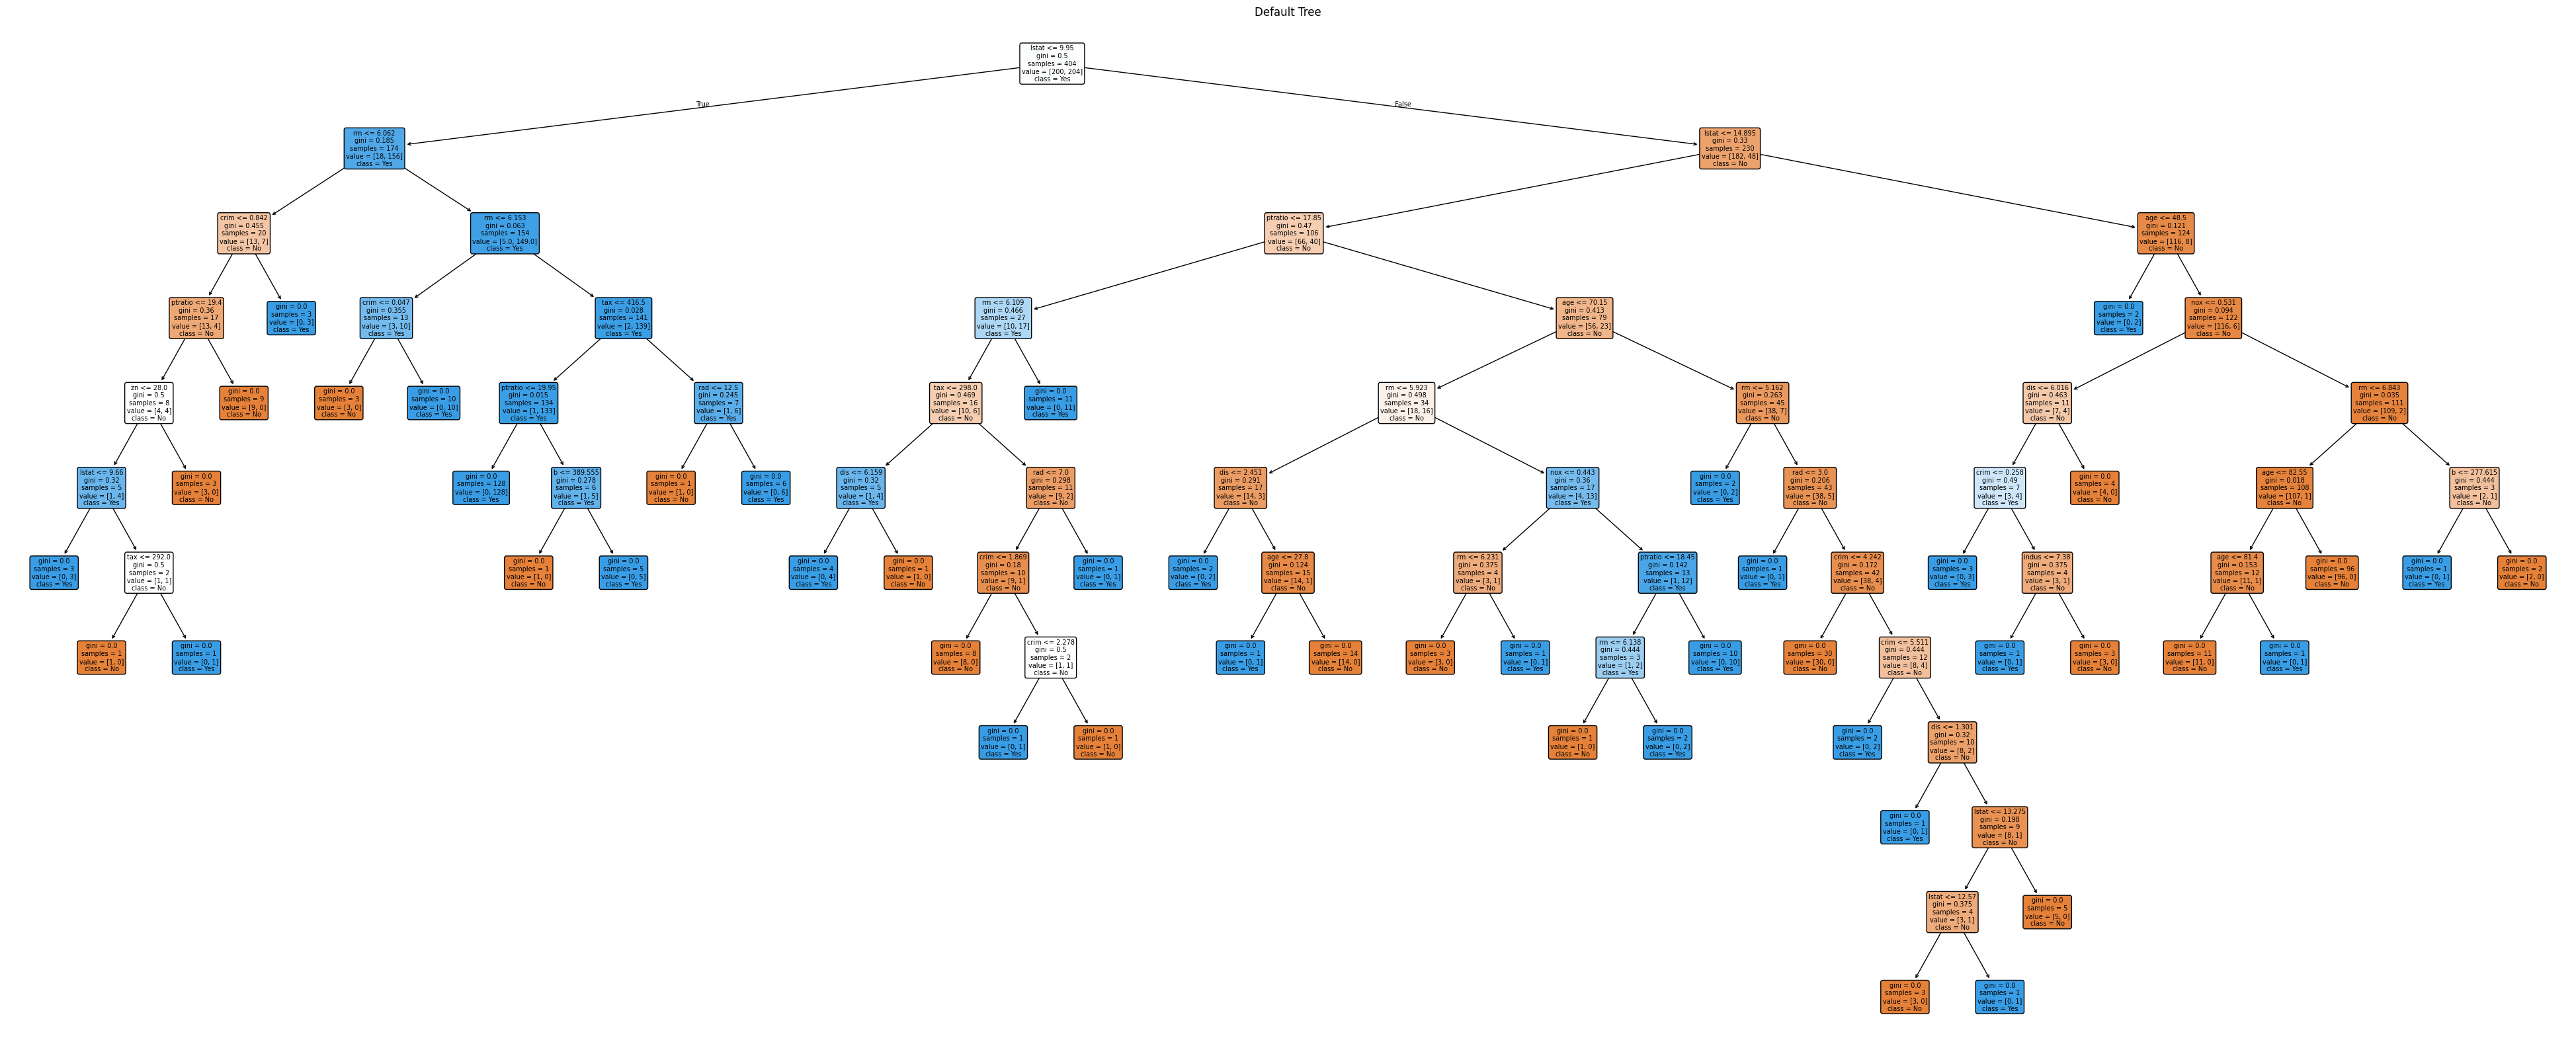

|--- lstat <= 9.95
|   |--- rm <= 6.06
|   |   |--- crim <= 0.84
|   |   |   |--- ptratio <= 19.40
|   |   |   |   |--- zn <= 28.00
|   |   |   |   |   |--- lstat <= 9.66
|   |   |   |   |   |   |--- weights: [0.00, 3.00] class: Yes
|   |   |   |   |   |--- lstat >  9.66
|   |   |   |   |   |   |--- tax <= 292.00
|   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: No
|   |   |   |   |   |   |--- tax >  292.00
|   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: Yes
|   |   |   |   |--- zn >  28.00
|   |   |   |   |   |--- weights: [3.00, 0.00] class: No
|   |   |   |--- ptratio >  19.40
|   |   |   |   |--- weights: [9.00, 0.00] class: No
|   |   |--- crim >  0.84
|   |   |   |--- weights: [0.00, 3.00] class: Yes
|   |--- rm >  6.06
|   |   |--- rm <= 6.15
|   |   |   |--- crim <= 0.05
|   |   |   |   |--- weights: [3.00, 0.00] class: No
|   |   |   |--- crim >  0.05
|   |   |   |   |--- weights: [0.00, 10.00] class: Yes
|   |   |--- rm >  6.15
|   |   |   |--- tax <

In [47]:
plt.figure(figsize=(50,20))
plot_tree(dtc,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=7)
plt.title("Default Tree")
plt.show()

print(export_text(dtc, feature_names=feature_names, show_weights=True))

In [48]:
# Generating ccp_alpha
path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Removing the maximum alpha value, which gives a trivial tree
ccp_alphas = ccp_alphas[:-1]

# Using GridSearchCV to find best ccp_alpha value
# GridSearchCV automatically uses cross-validation
param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_ccp_alpha = grid_search.best_params_['ccp_alpha']
# Model with the best ccp_alpha
dtc_pruned = grid_search.best_estimator_

print(f"Best ccp_alpha value found by GridSearchCV: {best_ccp_alpha:.4f}")

# Evaluation of the pruned tree on the training dataset
y_pred_train_pruned = dtc_pruned.predict(X_train)
print("\nPruned model (ccp_alpha) - train dataset evaluation:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train_pruned):.4f}")
print(f"Tree depth: {dtc_pruned.get_depth()}")
print(f"Amount of leaves: {dtc_pruned.get_n_leaves()}")

Best ccp_alpha value found by GridSearchCV: 0.0071

Pruned model (ccp_alpha) - train dataset evaluation:
Accuracy: 0.9233
Tree depth: 6
Amount of leaves: 12


In [49]:
clfs_viz = []
train_scores_viz = []
test_scores_viz = []
node_counts_viz = []
depths_viz = []

for i, alpha_val in enumerate(ccp_alphas):
    # It cant be negative, so we ensure it's non-negative
    current_alpha_for_tree = max(0, alpha_val)

    clf_viz_alpha = DecisionTreeClassifier(random_state=17, ccp_alpha=current_alpha_for_tree)
    clf_viz_alpha.fit(X_train, y_train)

    clfs_viz.append(clf_viz_alpha)
    train_scores_viz.append(clf_viz_alpha.score(X_train, y_train))
    test_scores_viz.append(clf_viz_alpha.score(X_test, y_test))
    node_counts_viz.append(clf_viz_alpha.tree_.node_count)
    depths_viz.append(clf_viz_alpha.get_depth())

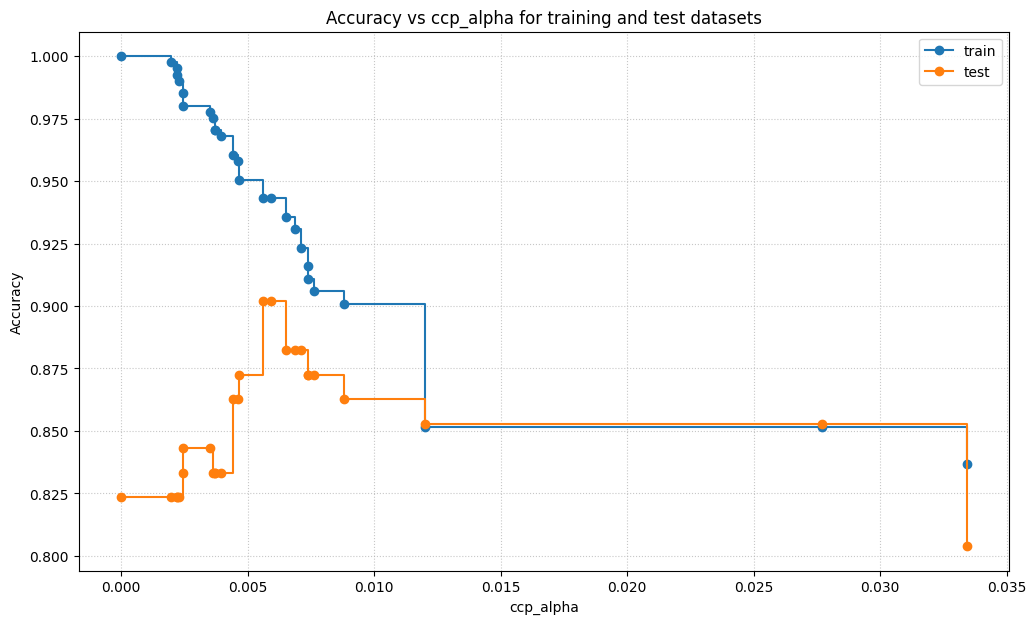

In [50]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs ccp_alpha for training and test datasets")
ax.plot(ccp_alphas, train_scores_viz, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_viz, marker='o', label="test", drawstyle="steps-post")

ax.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

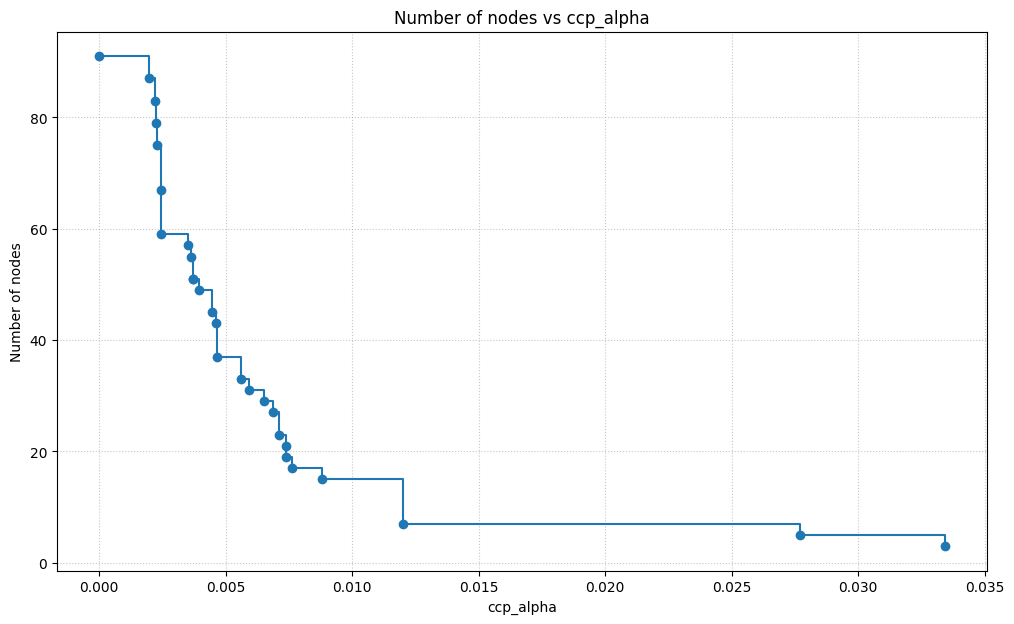

In [51]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ccp_alphas, node_counts_viz, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Number of nodes")
ax.set_title("Number of nodes vs ccp_alpha")

plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

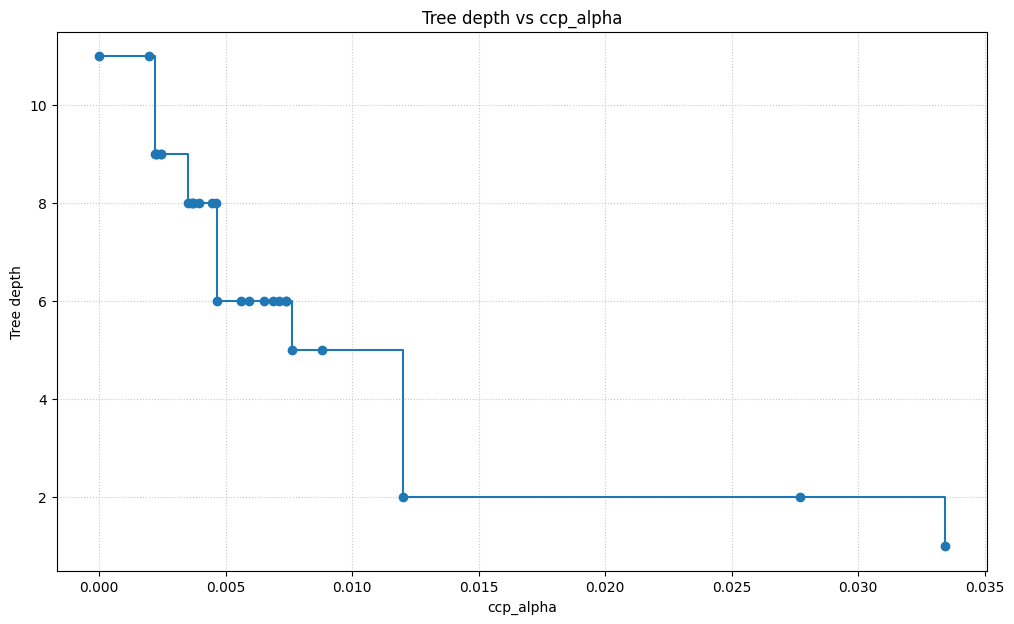

In [52]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ccp_alphas, depths_viz, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Tree depth")
ax.set_title("Tree depth vs ccp_alpha")

plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

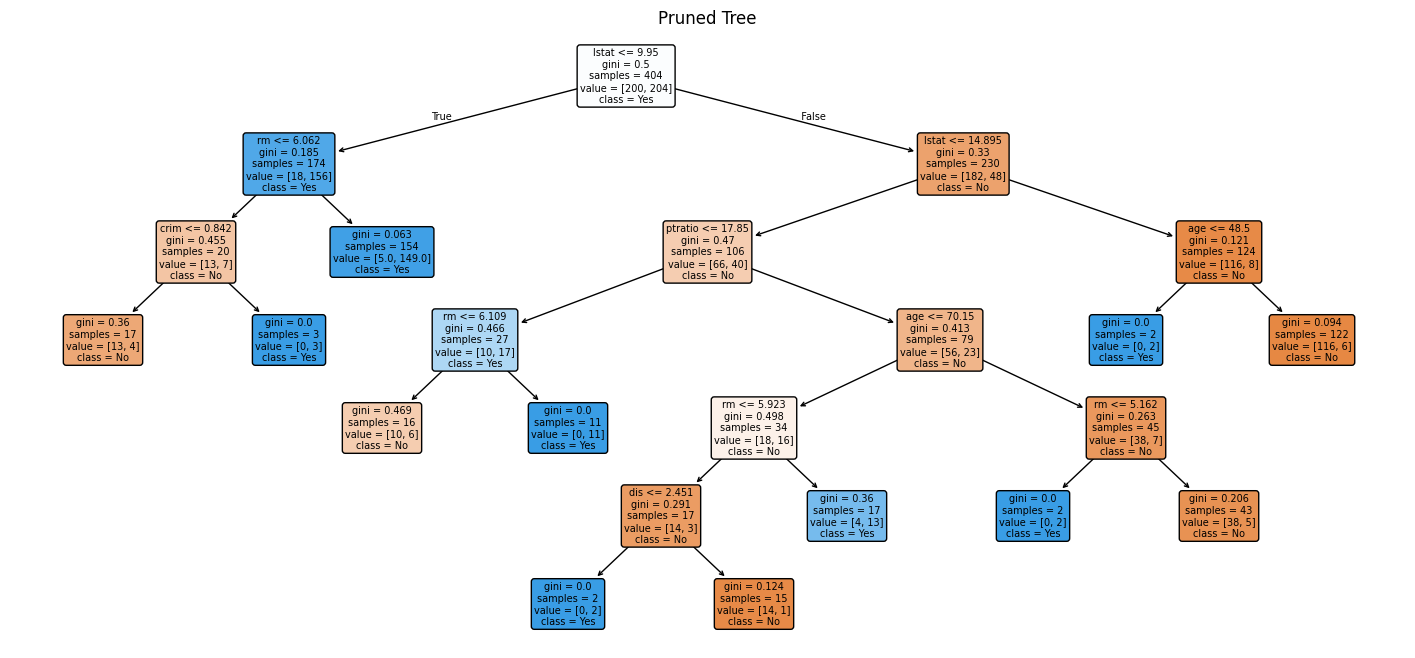

|--- lstat <= 9.95
|   |--- rm <= 6.06
|   |   |--- crim <= 0.84
|   |   |   |--- weights: [13.00, 4.00] class: No
|   |   |--- crim >  0.84
|   |   |   |--- weights: [0.00, 3.00] class: Yes
|   |--- rm >  6.06
|   |   |--- weights: [5.00, 149.00] class: Yes
|--- lstat >  9.95
|   |--- lstat <= 14.89
|   |   |--- ptratio <= 17.85
|   |   |   |--- rm <= 6.11
|   |   |   |   |--- weights: [10.00, 6.00] class: No
|   |   |   |--- rm >  6.11
|   |   |   |   |--- weights: [0.00, 11.00] class: Yes
|   |   |--- ptratio >  17.85
|   |   |   |--- age <= 70.15
|   |   |   |   |--- rm <= 5.92
|   |   |   |   |   |--- dis <= 2.45
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: Yes
|   |   |   |   |   |--- dis >  2.45
|   |   |   |   |   |   |--- weights: [14.00, 1.00] class: No
|   |   |   |   |--- rm >  5.92
|   |   |   |   |   |--- weights: [4.00, 13.00] class: Yes
|   |   |   |--- age >  70.15
|   |   |   |   |--- rm <= 5.16
|   |   |   |   |   |--- weights: [0.00, 2.00] class: Yes
| 

In [53]:
plt.figure(figsize=(18,8))
plot_tree(dtc_pruned,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=7)
plt.title("Pruned Tree")
plt.show()

print(export_text(dtc_pruned, feature_names=feature_names, show_weights=True))

In [54]:
# Evaluation on the test dataset
y_pred_test_default = dtc.predict(X_test)
y_pred_test_pruned = dtc_pruned.predict(X_test)

print("\nEvaluation on test data:")
print(f"Default model: Accuracy={accuracy_score(y_test, y_pred_test_default):.4f}")
print(f"Pruned model: Accuracy={accuracy_score(y_test, y_pred_test_pruned):.4f}")


Evaluation on test data:
Default model: Accuracy=0.8235
Pruned model: Accuracy=0.8824


In [55]:
print("Impact of `max_depth` (pre-pruning):")
depths = [3, 5, 7, 10, None] # None means no limit
results_depth = []

for depth in depths:
    dtc_max_depth = DecisionTreeClassifier(max_depth=depth, random_state=17)
    
    # Cross-validation on training data
    cv_scores = cross_val_score(dtc_max_depth, X_train, y_train, cv=5, scoring='accuracy')
    results_depth.append(cv_scores.mean())
    print(f"max_depth={depth}: Mean accuracy cross-validation = {cv_scores.mean():.4f}")

best_depth_idx = np.argmax(results_depth)
best_max_depth = depths[best_depth_idx]
print(f"\nBest `max_depth` based on cross-validation: {best_max_depth}")

dtc_best_depth = DecisionTreeClassifier(max_depth=best_max_depth, random_state=17)
dtc_best_depth.fit(X_train, y_train)
y_pred_test_best_depth = dtc_best_depth.predict(X_test)
print(f"\nModel with max_depth={best_max_depth}: Accuracy on test={accuracy_score(y_test, y_pred_test_best_depth):.4f}, Tree depth={dtc_best_depth.get_depth()}, Amount of leaves={dtc_best_depth.get_n_leaves()}")

Impact of `max_depth` (pre-pruning):
max_depth=3: Mean accuracy cross-validation = 0.8317
max_depth=5: Mean accuracy cross-validation = 0.7969
max_depth=7: Mean accuracy cross-validation = 0.8218
max_depth=10: Mean accuracy cross-validation = 0.8192
max_depth=None: Mean accuracy cross-validation = 0.8167

Best `max_depth` based on cross-validation: 3

Model with max_depth=3: Accuracy on test=0.8922, Tree depth=3, Amount of leaves=8


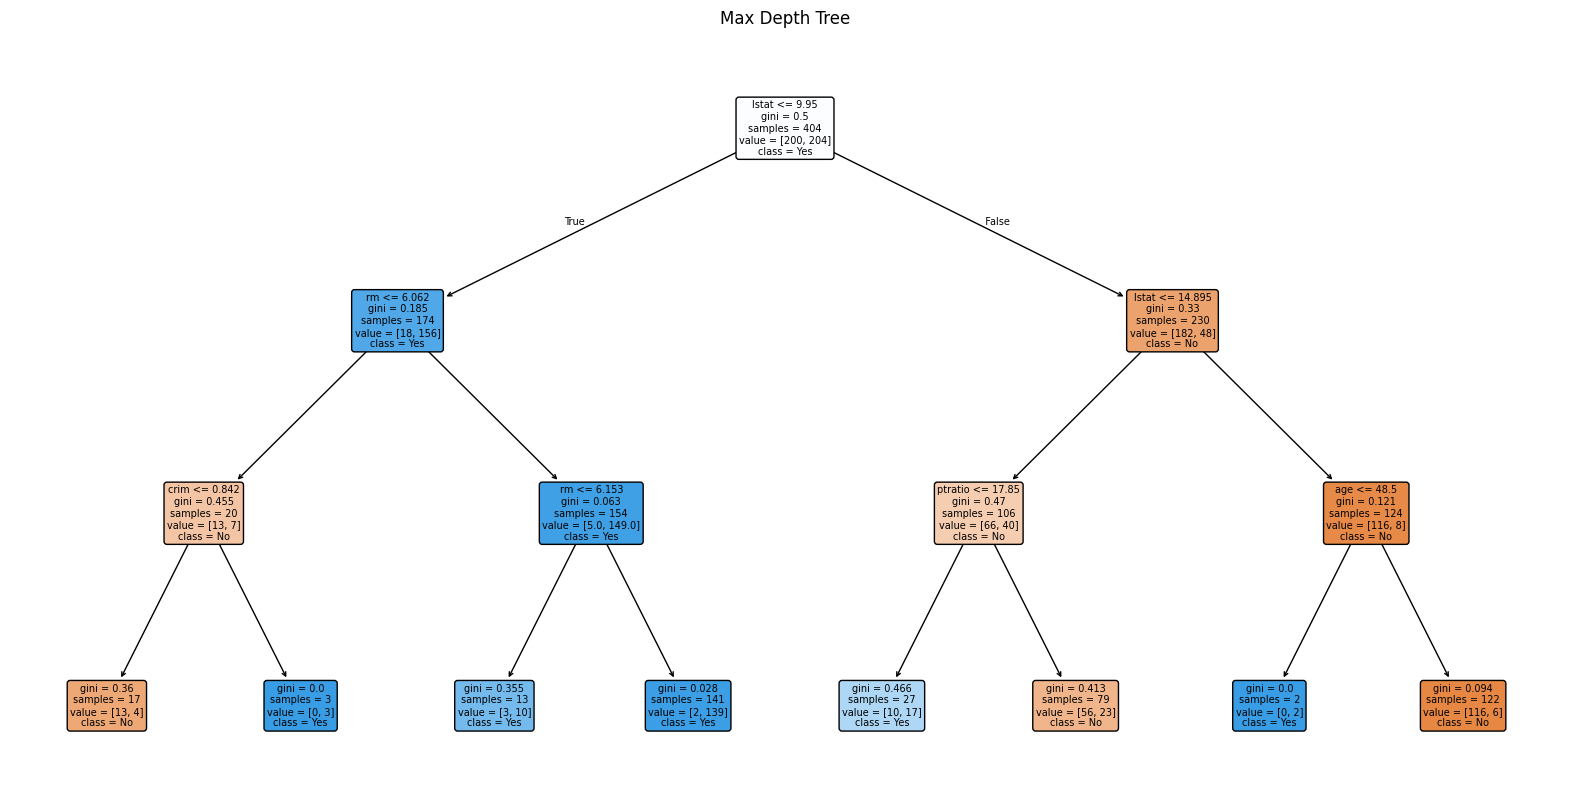

|--- lstat <= 9.95
|   |--- rm <= 6.06
|   |   |--- crim <= 0.84
|   |   |   |--- weights: [13.00, 4.00] class: No
|   |   |--- crim >  0.84
|   |   |   |--- weights: [0.00, 3.00] class: Yes
|   |--- rm >  6.06
|   |   |--- rm <= 6.15
|   |   |   |--- weights: [3.00, 10.00] class: Yes
|   |   |--- rm >  6.15
|   |   |   |--- weights: [2.00, 139.00] class: Yes
|--- lstat >  9.95
|   |--- lstat <= 14.89
|   |   |--- ptratio <= 17.85
|   |   |   |--- weights: [10.00, 17.00] class: Yes
|   |   |--- ptratio >  17.85
|   |   |   |--- weights: [56.00, 23.00] class: No
|   |--- lstat >  14.89
|   |   |--- age <= 48.50
|   |   |   |--- weights: [0.00, 2.00] class: Yes
|   |   |--- age >  48.50
|   |   |   |--- weights: [116.00, 6.00] class: No



In [56]:
plt.figure(figsize=(20,10))
plot_tree(dtc_best_depth,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=7)
plt.title("Max Depth Tree")
plt.show()

print(export_text(dtc_best_depth, feature_names=feature_names, show_weights=True))

### Random Forest

In [57]:
rf = RandomForestClassifier(random_state=17, n_estimators=100)
rf.fit(X_train, y_train)

y_test_rf = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_test_rf):.4f}")
print(f"\n{classification_report(y_test, y_test_rf)}")

Accuracy: 0.8824

              precision    recall  f1-score   support

          No       0.85      0.92      0.89        51
         Yes       0.91      0.84      0.88        51

    accuracy                           0.88       102
   macro avg       0.88      0.88      0.88       102
weighted avg       0.88      0.88      0.88       102



### Evaluation

In [58]:
print(f"Default model: Accuracy={accuracy_score(y_test, y_pred_test_default):.4f}")
print(f"Pruned model: Accuracy={accuracy_score(y_test, y_pred_test_pruned):.4f}")
print(f"Best max_depth model: Accuracy={accuracy_score(y_test, y_pred_test_best_depth):.4f}")
print(f"Random Forest model: Accuracy={accuracy_score(y_test, y_test_rf):.4f}")

Default model: Accuracy=0.8235
Pruned model: Accuracy=0.8824
Best max_depth model: Accuracy=0.8922
Random Forest model: Accuracy=0.8824
